# Advanced Model Evaluation: Improving Cyber Risk Prediction with Regularization

### Project Context (Week 8)

This notebook executes the Week 8 objectives by extending the baseline model established in Week 7. The focus shifts from basic modeling to **advanced regression techniques** and **rigorous engineering evaluation**.

**Objective:** To investigate whether advanced regression methods (specifically Ridge/Lasso or Polynomial Regression) can **improve the predictive performance** and **model robustness** compared to the Week 7 Linear Regression baseline ($R^2=0.8486$). This involves calculating new evaluation metrics like **MAE**.

**Data Source:** Data obtained from the research study: [Quantification of the Global Cyber Threat Landscape: An ML-Based Assessment](https://www.mdpi.com/2078-2489/15/4/199).

**Target Variable:** The target variable for all models remains the **Log-transformed Local Infection** rate. This section will conclude with a **reflection** on the best model and the importance of efficient code **refactoring** (the engineering mindset).

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  IPython.display import display
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

### Data Loading and Initial Checks

In [2]:
# Load data
df = pd.read_csv('cyber_data.csv')
df

,AttackDate,Country,Spam,Ransomware,Local Infection,Exploit,Malicious Mail,Network Attack,On Demand Scan,Web Threat,Rank Spam,Rank Ransomware,Rank Local Infection,Rank Exploit,Rank Malicious Mail,Rank Network Attack,Rank On Demand Scan,Rank Web Threat
0,11/10/2022 0:00,Arab Republic of Egypt,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01148,0.01708,68,47,85,176,34,11,78,53
1,11/10/2022 0:00,Argentine Republic,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00482,0.00974,27,86,174,128,140,138,174,160
2,11/10/2022 0:00,Aruba,NaN,NaN,0.01384,NaN,0.00092,NaN,0.00830,0.00554,162,143,82,186,104,187,119,190
3,11/10/2022 0:00,Bailiwick of Guernsey,NaN,NaN,0.00546,0.00273,NaN,0.00091,0.00546,0.01001,162,143,179,1,186,141,164,159
4,11/10/2022 0:00,Bailiwick of Jersey,0.00003,NaN,0.00774,0.00101,0.00067,NaN,0.00707,0.01145,138,143,150,31,133,187,137,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,11/12/2023 0:00,United Arab Emirates,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.00892,0.01274,86,37,100,43,2,40,42,87
77619,11/12/2023 0:00,United Kingdom of Great Britain and Northern I...,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.00382,0.01205,12,89,173,14,97,139,171,100
77620,11/12/2023 0:00,United Mexican States,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00772,0.00834,34,77,106,122,65,68,74,152
77621,11/12/2023 0:00,United Republic of Tanzania,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.00717,0.01145,101,116,54,83,77,83,92,114


### Data Cleaning

In [16]:
#Make a copy of the dataframe for cleaning and to serve as a savepoint
df_cleaned = df.copy()

In [17]:
cols_to_drop = [x for x in df_cleaned.columns if 'Rank' in x]
cols_to_drop = cols_to_drop + ['On Demand Scan']
cols_to_drop

['Rank Spam',
 'Rank Ransomware',
 'Rank Local Infection',
 'Rank Exploit',
 'Rank Malicious Mail',
 'Rank Network Attack',
 'Rank On Demand Scan',
 'Rank Web Threat',
 'On Demand Scan']

In [18]:
df_cleaned = df_cleaned.drop(columns = cols_to_drop, axis = 1)
df_cleaned.columns

Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local Infection',
       'Exploit', 'Malicious Mail', 'Network Attack', 'Web Threat'],
      dtype='object')

##### Renaming of variables

In [19]:
"""Column names before cleaning:"""
print(df.columns)
print("-" * 50)

# Fix the names by replacing spaces with underscore
fixed_names = {col: col.replace(' ', '_') for col in df_cleaned.columns}
df_cleaned.rename(columns = fixed_names, inplace = True)

"""Column names after cleaning:"""
print(df_cleaned.columns)

Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local Infection',
       'Exploit', 'Malicious Mail', 'Network Attack', 'On Demand Scan',
       'Web Threat', 'Rank Spam', 'Rank Ransomware', 'Rank Local Infection',
       'Rank Exploit', 'Rank Malicious Mail', 'Rank Network Attack',
       'Rank On Demand Scan', 'Rank Web Threat'],
      dtype='object')
--------------------------------------------------
Index(['AttackDate', 'Country', 'Spam', 'Ransomware', 'Local_Infection',
       'Exploit', 'Malicious_Mail', 'Network_Attack', 'Web_Threat'],
      dtype='object')


##### Handling of Nulls

In [20]:
"""
Earlier, we found that the columns below have nulls. 
To determine the best approach on how to handle this, we need to: 
- Consider the level of completeness first to see if we can drop all rows where there are nulls.
- Check if we can apply imputation and which type of imputation.
"""

null_list = [
            'Spam',
            'Ransomware',
            'Local_Infection',
            'Exploit',
            'Malicious_Mail',
            'Network_Attack',
            'Web_Threat',
]
null_list

# Make a copy of the df where only those in null_list exist for ease of use.
df_nulls = df_cleaned[null_list] 

In [25]:
# Imputing using median
for col in null_list:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77623 entries, 0 to 77622
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AttackDate       77623 non-null  object 
 1   Country          77623 non-null  object 
 2   Spam             77623 non-null  float64
 3   Ransomware       77623 non-null  float64
 4   Local_Infection  77623 non-null  float64
 5   Exploit          77623 non-null  float64
 6   Malicious_Mail   77623 non-null  float64
 7   Network_Attack   77623 non-null  float64
 8   Web_Threat       77623 non-null  float64
dtypes: float64(7), object(2)
memory usage: 5.3+ MB


### Feature Engineering

Since the data cleaning has been completed, we'll need to look at the following for feature engineering:
- Encoding of Country
- Date and time features creation: We can use AttackDate here and encode it by year, month, and day to see if there are seasonal patterns or trends on the attacks. We can also try to extract the day of the week and time features to know when the attacks usually happen.
- Interaction Features and Polynomial Features
    - Looking at the data that we have, there are a lot of features with extreme right-skewness which will potentially lead to a higher leverage point that skews the model's coefficients and residuals. 
    - Plan is to apply log transformation on highly skewed features and on the target variable to normalize the distributions and make the assumption of normally distributed residuals for linear regression.

##### Encoding of Country

In [27]:
# Get the count of columns to be added
data_ohe = df_cleaned.copy()
len(data_ohe['Country'].unique())-1 # k-1

224

In [28]:
# Encode the countries
country_dummies = pd.get_dummies(data_ohe['Country'], drop_first = True)
country_dummies

,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,Union of the Comoros,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,United Mexican States,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
77619,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
77620,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
77621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [29]:
# Concatenate and delete 'Country' column
df_cleaned = df_cleaned.reset_index(drop=True)
country_dummies = country_dummies.reset_index(drop=True)
df_cleaned = pd.concat([df_cleaned, country_dummies], axis=1)
df_cleaned = df_cleaned.drop('Country', axis=1)
df_cleaned


,AttackDate,Spam,Ransomware,Local_Infection,Exploit,Malicious_Mail,Network_Attack,Web_Threat,Antarctica,Antigua and Barbuda,...,Union of the Comoros,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,United Mexican States,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands
0,11/10/2022 0:00,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01708,False,False,...,False,False,False,False,False,False,False,False,False,False
1,11/10/2022 0:00,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00974,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11/10/2022 0:00,0.00059,0.00007,0.01384,0.00039,0.00092,0.00129,0.00554,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11/10/2022 0:00,0.00059,0.00007,0.00546,0.00273,0.00073,0.00091,0.01001,False,False,...,False,False,False,False,False,False,False,False,False,False
4,11/10/2022 0:00,0.00003,0.00007,0.00774,0.00101,0.00067,0.00129,0.01145,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,11/12/2023 0:00,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.01274,False,False,...,False,True,False,False,False,False,False,False,False,False
77619,11/12/2023 0:00,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.01205,False,False,...,False,False,True,False,False,False,False,False,False,False
77620,11/12/2023 0:00,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00834,False,False,...,False,False,False,True,False,False,False,False,False,False
77621,11/12/2023 0:00,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.01145,False,False,...,False,False,False,False,True,False,False,False,False,False


##### Date and time features creation

First we need to convert AttackDate to datetime then we will extract the basic temporal features:
- Year
- Month
- Date

Then extract the time-based features:
- Day of week
- Hour
- Time of day

For Time of Day, I'll split it into the following categories and definitions:
- Morning - 5AM to before 12NN
- Afternoon - 12NN to before 5PM
- Evening - 5PM to before 9PM
- Night - 9PM to before 5AM
This segregation allows us to determine when the time of attack were and allows the model to uncover trends in the data.

In [30]:
# Convert AttackDate to datetime format
df_cleaned['AttackDate'] = pd.to_datetime(df_cleaned['AttackDate'], dayfirst = True)

In [31]:
# Basic temporal features creation
df_cleaned['Year'] = df_cleaned['AttackDate'].dt.year
df_cleaned['Month'] = df_cleaned['AttackDate'].dt.month
df_cleaned['Day'] = df_cleaned['AttackDate'].dt.day

In [32]:
# Time-based features creation

df_cleaned['Day_of_Week'] = df_cleaned['AttackDate'].dt.dayofweek
df_cleaned['Hour'] = df_cleaned['AttackDate'].dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
df_cleaned['Time_of_Day'] = df_cleaned['Hour'].apply(get_time_of_day)

In [33]:
for i in ['Year', 'Month', 'Day', 'Day_of_Week', 'Hour', 'Time_of_Day']:
    display(df_cleaned[i].value_counts())
    print('-' *100)

Year
2023    62124
2022    15499
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Month
11    11077
10     9535
12     8159
4      5929
1      5912
5      5729
2      5560
3      5539
7      5533
6      5328
9      4775
8      4547
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Day
7     2789
18    2785
11    2779
10    2779
4     2778
21    2774
28    2769
9     2769
15    2764
16    2752
6     2596
13    2589
20    2585
22    2578
19    2578
8     2577
17    2572
3     2570
27    2568
5     2401
14    2398
12    2389
24    2369
23    2367
2     2366
1     2358
29    2346
25    2175
26    1975
30    1959
31    1569
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Day_of_Week
0    11696
1    11500
4    11298
3    11268
2    11239
5    10496
6    10126
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Hour
0    77623
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


Time_of_Day
Night    77623
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


We can see that Hour and Time_of_Day has no categories as timestamps don't exist in the data. We should drop these along with the AttackDate column.

In [34]:
df_cleaned = df_cleaned.drop(['AttackDate', 'Hour', 'Time_of_Day'], axis=1)
df_cleaned

,Spam,Ransomware,Local_Infection,Exploit,Malicious_Mail,Network_Attack,Web_Threat,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,...,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands,Year,Month,Day,Day_of_Week
0,0.00090,0.00013,0.01353,0.00013,0.00287,0.01007,0.01708,False,False,True,...,False,False,False,False,False,False,2022,10,11,1
1,0.00601,0.00006,0.00575,0.00035,0.00058,0.00095,0.00974,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
2,0.00059,0.00007,0.01384,0.00039,0.00092,0.00129,0.00554,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
3,0.00059,0.00007,0.00546,0.00273,0.00073,0.00091,0.01001,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
4,0.00003,0.00007,0.00774,0.00101,0.00067,0.00129,0.01145,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,0.00064,0.00009,0.00901,0.00057,0.00198,0.00149,0.01274,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77619,0.01292,0.00003,0.00428,0.00084,0.00021,0.00045,0.01205,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77620,0.00500,0.00004,0.00870,0.00019,0.00035,0.00106,0.00834,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77621,0.00030,0.00002,0.01201,0.00031,0.00028,0.00091,0.01145,False,False,False,...,True,False,False,False,False,False,2023,12,11,0


##### Interaction Features and Polynomial Features

Log Transformations

In [35]:
# Call null_list to check current list of features to apply polynomial features on
polynomial_cols = null_list
polynomial_cols

['Spam',
 'Ransomware',
 'Local_Infection',
 'Exploit',
 'Malicious_Mail',
 'Network_Attack',
 'Web_Threat']

In [36]:
log_name_list = []
for col in polynomial_cols:
    print(f'Applying log transformation to {col}')
    log_name = f'Log_{col}'
    log_name_list.append(log_name)
    df_cleaned[log_name] = np.log1p(df_cleaned[col])
print('All log transformations applied, see output table below:')
df_cleaned[log_name_list]

Applying log transformation to Spam
Applying log transformation to Ransomware
Applying log transformation to Local_Infection
Applying log transformation to Exploit
Applying log transformation to Malicious_Mail
Applying log transformation to Network_Attack
Applying log transformation to Web_Threat
All log transformations applied, see output table below:


,Log_Spam,Log_Ransomware,Log_Local_Infection,Log_Exploit,Log_Malicious_Mail,Log_Network_Attack,Log_Web_Threat
0,0.000900,0.00013,0.013439,0.000130,0.002866,0.010020,0.016936
1,0.005992,0.00006,0.005734,0.000350,0.000580,0.000950,0.009693
2,0.000590,0.00007,0.013745,0.000390,0.000920,0.001289,0.005525
3,0.000590,0.00007,0.005445,0.002726,0.000730,0.000910,0.009960
4,0.000030,0.00007,0.007710,0.001009,0.000670,0.001289,0.011385
...,...,...,...,...,...,...,...
77618,0.000640,0.00009,0.008970,0.000570,0.001978,0.001489,0.012660
77619,0.012837,0.00003,0.004271,0.000840,0.000210,0.000450,0.011978
77620,0.004988,0.00004,0.008662,0.000190,0.000350,0.001059,0.008305
77621,0.000300,0.00002,0.011938,0.000310,0.000280,0.000910,0.011385


In [37]:
# Now that the log transformations are applied, lets duplicate the df and drop the columns where log transformations were applied from:
df_cleaned_2 = df_cleaned.copy()

#Now lets drop polynomials columns
df_cleaned_2 = df_cleaned_2.drop(columns = polynomial_cols, axis = 1)
df_cleaned_2.columns

Index(['Antarctica', 'Antigua and Barbuda', 'Arab Republic of Egypt',
       'Argentine Republic', 'Aruba', 'Bailiwick of Guernsey',
       'Bailiwick of Jersey', 'Barbados', 'Belize', 'Bermuda',
       ...
       'Month', 'Day', 'Day_of_Week', 'Log_Spam', 'Log_Ransomware',
       'Log_Local_Infection', 'Log_Exploit', 'Log_Malicious_Mail',
       'Log_Network_Attack', 'Log_Web_Threat'],
      dtype='object', length=235)

Now that the log transformations have finished. Lets create another df as a savepoint before we create polynomial features so we can use it to loop back whenever we need it.

In [38]:
df_model_ready = df_cleaned_2.copy()
df_model_ready[log_name_list]

,Log_Spam,Log_Ransomware,Log_Local_Infection,Log_Exploit,Log_Malicious_Mail,Log_Network_Attack,Log_Web_Threat
0,0.000900,0.00013,0.013439,0.000130,0.002866,0.010020,0.016936
1,0.005992,0.00006,0.005734,0.000350,0.000580,0.000950,0.009693
2,0.000590,0.00007,0.013745,0.000390,0.000920,0.001289,0.005525
3,0.000590,0.00007,0.005445,0.002726,0.000730,0.000910,0.009960
4,0.000030,0.00007,0.007710,0.001009,0.000670,0.001289,0.011385
...,...,...,...,...,...,...,...
77618,0.000640,0.00009,0.008970,0.000570,0.001978,0.001489,0.012660
77619,0.012837,0.00003,0.004271,0.000840,0.000210,0.000450,0.011978
77620,0.004988,0.00004,0.008662,0.000190,0.000350,0.001059,0.008305
77621,0.000300,0.00002,0.011938,0.000310,0.000280,0.000910,0.011385


Polynomial Features

In [39]:
# Let's remove log_local_infection first from the list and name it as as polyfeatures

polyfeatures = log_name_list.copy()
polyfeatures.remove('Log_Local_Infection')
polyfeatures

['Log_Spam',
 'Log_Ransomware',
 'Log_Exploit',
 'Log_Malicious_Mail',
 'Log_Network_Attack',
 'Log_Web_Threat']

In [40]:
# Initialize the transformer
poly = PolynomialFeatures(degree = 2, include_bias = False)

# Fit and transform the data
X_poly =poly.fit_transform(df_model_ready[polyfeatures])
poly_feature_names = poly.get_feature_names_out(polyfeatures)
df_poly_features = pd.DataFrame(X_poly, columns=poly_feature_names, index=df_model_ready.index)

print(f"Generated {len(poly_feature_names)} new polynomial and interaction features.")

Generated 27 new polynomial and interaction features.


### Model Building and Training

Data Preparation for Modelling

In [41]:
# Define target
target_col = 'Log_Local_Infection'
target_col

'Log_Local_Infection'

In [42]:
# Separate the target from the dataset
y = df_model_ready[target_col]
y

0        0.013439
1        0.005734
2        0.013745
3        0.005445
4        0.007710
           ...   
77618    0.008970
77619    0.004271
77620    0.008662
77621    0.011938
77622    0.006320
Name: Log_Local_Infection, Length: 77623, dtype: float64

In [43]:
# Separate features
X_base = df_model_ready.drop(columns=[target_col])
log_cols_to_drop = [col for col in X_base.columns if col.startswith('Log_')]
X_base_dropped = X_base.drop(columns=log_cols_to_drop)
X_base_dropped

,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,United Republic of Tanzania,United States of America,Vatican City State,Virgin Islands,Virgin Islands of the United States,Åland Islands,Year,Month,Day,Day_of_Week
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,2022,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77618,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77619,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77620,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023,12,11,0
77621,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,2023,12,11,0


In [44]:
# Concat cleaned base data with new polynomial features
X = pd.concat([X_base_dropped, df_poly_features], axis=1)
print(f"Final Predictor Matrix (X) Shape: {X.shape}")
X.head(10)

Final Predictor Matrix (X) Shape: (77623, 255)


,Antarctica,Antigua and Barbuda,Arab Republic of Egypt,Argentine Republic,Aruba,Bailiwick of Guernsey,Bailiwick of Jersey,Barbados,Belize,Bermuda,...,Log_Exploit^2,Log_Exploit Log_Malicious_Mail,Log_Exploit Log_Network_Attack,Log_Exploit Log_Web_Threat,Log_Malicious_Mail^2,Log_Malicious_Mail Log_Network_Attack,Log_Malicious_Mail Log_Web_Threat,Log_Network_Attack^2,Log_Network_Attack Log_Web_Threat,Log_Web_Threat^2
0,False,False,True,False,False,False,False,False,False,False,...,1.689780e-08,3.725414e-07,1.302468e-06,0.000002,8.213322e-06,2.871517e-05,4.853606e-05,1.003931e-04,1.696903e-04,0.000287
1,False,False,False,True,False,False,False,False,False,False,...,1.224571e-07,2.029056e-07,3.322840e-07,0.000003,3.362050e-07,5.505788e-07,5.620236e-06,9.016434e-07,9.203857e-06,0.000094
2,False,False,False,False,True,False,False,False,False,False,...,1.520407e-07,3.585651e-07,5.026778e-07,0.000002,8.456220e-07,1.185490e-06,5.080397e-06,1.661956e-06,7.122284e-06,0.000031
3,False,False,False,False,False,True,False,False,False,False,...,7.432604e-06,1.989459e-06,2.479787e-06,0.000027,5.325112e-07,6.637557e-07,7.268317e-06,8.273471e-07,9.059689e-06,0.000099
4,False,False,False,False,False,False,True,False,False,False,...,1.019071e-06,6.761320e-07,1.301403e-06,0.000011,4.485994e-07,8.634538e-07,7.625359e-06,1.661956e-06,1.467711e-05,0.000130
5,False,False,False,False,False,False,False,True,False,False,...,3.718731e-07,4.450018e-07,1.492217e-06,0.000010,5.325112e-07,1.785661e-06,1.154740e-05,5.987827e-06,3.872172e-05,0.000250
6,False,False,False,False,False,False,False,False,True,False,...,1.763259e-07,1.175589e-07,5.878354e-08,0.000008,7.837805e-08,3.919177e-08,5.299573e-06,1.959726e-08,2.649972e-06,0.000358
7,False,False,False,False,False,False,False,False,False,False,...,1.088641e-07,1.748248e-07,2.501380e-06,0.000005,2.807512e-07,4.016966e-06,8.530581e-06,5.747444e-05,1.220549e-04,0.000259
8,False,False,False,False,False,False,False,False,False,False,...,2.559590e-08,7.342536e-07,2.078483e-07,0.000003,2.106307e-05,5.962413e-06,7.226271e-05,1.687806e-06,2.045571e-05,0.000248
9,False,False,False,False,False,False,False,False,False,False,...,1.023672e-07,3.519243e-08,5.438668e-08,0.000002,1.209867e-08,1.869738e-08,6.273728e-07,2.889509e-08,9.695471e-07,0.000033


Train/Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Feature Scaling

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split and scaled successfully.")

Data split and scaled successfully.


Model Training

In [47]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print("Training completed.")

Training completed.


### Initial Evaluation and Iteration

In [48]:
y_pred_test = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n--- Model Performance on Test Set ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- Model Performance on Test Set ---
R-squared (R²): 0.8486
Root Mean Squared Error (RMSE): 0.0032


Looking at the results, we can see that the R squared is 0.8486 indicating that the log-transformed dataset worked well as the skewness was addressed which lead to a more stable model and the polynomial features allowed the model to fit the non-linear curved relationship identified in the boxplots - both of these steps resulted to the model capturing around 84.86% of the variance.

To further understand the result, we must check the biggest drivers to also know which attack type has the highest positive coefficient as this will be the primary driver of infection.

In [49]:
feature_names = X.columns
coefficients = model.coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df

,Feature,Coefficient
0,Antarctica,-0.000004
1,Antigua and Barbuda,-0.000022
2,Arab Republic of Egypt,-0.000174
3,Argentine Republic,-0.000087
4,Aruba,0.000041
...,...,...
250,Log_Malicious_Mail Log_Network_Attack,-0.000508
251,Log_Malicious_Mail Log_Web_Threat,-0.001194
252,Log_Network_Attack^2,-0.001102
253,Log_Network_Attack Log_Web_Threat,-0.000263


In [50]:
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
top_impact_features = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)
print("Top 10 Impactful Drivers")
print(top_impact_features.head(10))

Top 10 Impactful Drivers
                 Feature  Coefficient  Absolute_Coefficient
233       Log_Web_Threat     0.008030              0.008030
254     Log_Web_Threat^2    -0.004024              0.004024
230          Log_Exploit     0.002714              0.002714
232   Log_Network_Attack     0.002608              0.002608
231   Log_Malicious_Mail     0.002549              0.002549
111    Republic of Benin     0.001476              0.001476
209    Togolese Republic     0.001433              0.001433
114  Republic of Burundi     0.001350              0.001350
12          Burkina Faso     0.001342              0.001342
211         Turkmenistan     0.001333              0.001333


Looking at the top drivers, we can definitely see that the Log Web Threat and its power of 2 counterpart drives the local infection rate higher abd we can definitely see it as a main driver given the gap between the coefficient values to the third one.

We can conclude that most of the attacks that drive the local infection rate higher are internet-borne risks as seen with Web Threats and its understandable given that most of the successful web threat attacks likely bore from individuals with lesser digital security literacy which leads to their devices getting compromised.

Looking into the other attack drivers, we can definitely see that the range is between 0.0025-0.0027 and these attacks are on the software and hardware side which requires an advanced understanding of the systems in order for a successful attack to be done. We can also see that malicious mail is also one of the top drivers, while this can be related to web threats due to phishing, the variable was left as is to further check if these social engineering attacks pose a higher risks as compared to the other attacks. 

There are also a few countries included in the top drivers and upon checking, these are developing countries. Most of these are African Countries which are seeing a rapid growth in internet and mobile use in the past few years but the fast digital transformation is outpaced by the development of adequate security measures which makes these countries prime targets of attacks. 

Given the low cybersecurity maturity, this makes them susceptible targets to cyber attacks such as:
- Online Scams and Phishing
- Malware and Ransomware
- and Business Email Compromise

Some attacks confirmed by other studies in the International Analytics Group of PT Cyber Analytics
[as seen here.](https://global.ptsecurity.com/en/research/analytics/cybersecurity-threatscape-for-african-countries-q1-2023-q3-2024/). We can see that while the metrics did not make any mention of said countries, given that these are the top in the said market, these likely reflect in the other countries that weren't mentioned.

We can also see in the [Global Cybersecurity Index (GCI)](https://www.itu.int/epublications/publication/global-cybersecurity-index-2024) from ITU that the Republic of Burundi was ranked in one of the lowest tiers which further supports our findings. 

Turkmenistan came in as the 10th driver but this could be due to the idea of it being a developing region, the institutional fragmentation leads to lesser capacity to handle incidents. 

Looking at the impactful drivers, we can definitely say that most of the attacks are highly centered on web threats which indicates that there should be a push to make the public more digitally literate in terms of handling these items. The findings also show that there should be a stricter implementation in cybersecurity for both hardware and software alike to ensure that these will be less likely to be compromised. 

While most of the drivers tackled are from the top 10 only, it is important to still ensure that the security is enough to handle other cyber attacks as it is possible and given that the continuing rise in AI is very rapid, along comes the risk of attacks that may stem from it be it driven by ill interest or use of AI to learn how to attack certain systems or demographics. It is best to be literate even on the basics rather than not being literate at all because while we are building smart systems, we must ensure that the user, be it an end-user or not, is also smart when they are utilizing such tools.


### Final Evaluation, Driver Analysis, and Recommendations

The Multiple Linear Regression model, leveraging log-transformed and polynomial features, achieved an R-squared (R 
2
 ) of 0.8486 on the test set. This confirms that the model successfully explains approximately 85% of the variance in the log-transformed local infection rate, validating the entire feature engineering strategy (Log Transformation and Polynomial terms).

##### The Top 10 Impactful Drivers
The following table presents the features with the largest absolute coefficients, indicating the strongest positive (or negative, in the case of the squared term) influence on the Log_Local_Infection rate.

In [51]:
display(top_impact_features.head(10))

,Feature,Coefficient,Absolute_Coefficient
233,Log_Web_Threat,0.008030,0.008030
254,Log_Web_Threat^2,-0.004024,0.004024
230,Log_Exploit,0.002714,0.002714
232,Log_Network_Attack,0.002608,0.002608
231,Log_Malicious_Mail,0.002549,0.002549
111,Republic of Benin,0.001476,0.001476
209,Togolese Republic,0.001433,0.001433
114,Republic of Burundi,0.001350,0.001350
12,Burkina Faso,0.001342,0.001342
211,Turkmenistan,0.001333,0.001333


Below are the assessments of each driver with the findings after checking the domain as refence.

1. **Log_Web_Threat**: +0.008030, **Highest Positive Driver**. The single strongest predictor, indicating a direct relationship with successful local infections.
2. **Log_Web_Threat2**: -0.004024, **Non-Linear Effect**. A high magnitude confirms the non-linear relationship, suggesting a diminishing return on impact at extremely high volumes of web threats.
3. **Log_Exploit**: +0.002714, **Software Vulnerability**. Direct attacks targeting system weaknesses are highly effective.
4. **Log_Network_Attack**: +0.002608, **Perimeter Threats**. Significant driver from infrastructure-level attacks.
5. **Log_Malicious_Mail**: +0.002549, **Social Engineering**. Highlights the persistent success of phishing and email-borne malware.
6. **Republic of Benin**: +0.001476, **Geographical Factor**. Vulnerability linked to low maturity.
7. **Togolese Republic**: +0.001433, **Geographical Factor**. Vulnerability linked to low maturity.
8. **Republic of Burundi**: +0.001350, **Geographical Factor**. Vulnerability linked to low maturity.
9. **Burkina Faso**: +0.001342, **Geographical Factor**. Vulnerability linked to low maturity.
10. **Turkmenistan**: +0.001333, **Geographical Factor**. Vulnerability linked to developing region status.

#### Dominance of Web Threats (User-driven Risk) 

The model confirms that Web Threats are the primary attack vector, leading to the highest local infection rate. Given the significant gap between the coefficient of Log_Web_Threat (+0.0080) and the next largest attack type (Log_Exploit at +0.0027), we conclude that the most successful attacks are internet-borne risks that often rely on a user's lack of digital security literacy (e.g., clicking on phishing links, visiting malicious sites) to compromise the device.

#### Consistency of Technical Attacks

While Web Threats dominate, the clusters of Log_Exploit, Log_Network_Attack, and Log_Malicious_Mail (ranging from 0.0025 to 0.0027) confirm that attacks on the software/hardware layer requiring advanced understanding remain a significant, sustained threat.

#### Geographical Vulnerability and Low Maturity

The presence of multiple developing countries (e.g., Republic of Benin, Republic of Burundi, Togolese Republic) among the top drivers points to a critical systemic vulnerability. This finding is supported by external data:
- These regions are experiencing rapid digital transformation which has outpaced the development of robust security measures and user education.

- The Global Cybersecurity Index (GCI) from the ITU often ranks these nations in lower tiers than T1, supporting the model's conclusion that low cybersecurity maturity is directly correlated with a higher baseline rate of successful infections. We can also see that while the Republic of Benin and Togolese Republic are in the T2 or advancing tier, it is in our top impactful drivers as we expect that with more awareness and efforts to improve security, it is possible that the infection rate gets higher due to increased detection efforts. The important idea here is that they are moving toward advancing their security.


Policy and Strategic Implications


The findings from this Multiple Linear Regression model translate into clear action items for cybersecurity strategy:

1. Prioritize Digital Literacy: The overwhelming impact of Log_Web_Threat necessitates a global push for basic digital security education for end-users. This represents the most effective mitigation strategy against the largest single driver of infection.

2. Strengthen Base Defenses: Strict implementation of cybersecurity principles for both hardware and software development is required to reduce the effectiveness of Log_Exploit and Log_Network_Attack.

3. Future-Proofing: While the current drivers are clear, the rapid development of AI-driven attacks means organizations must ensure security baselines are robust enough to handle new threats that learn to target systems or demographics. Security must be continuously evolved to match the sophistication of emerging tools.


To further check the other features where there can be improvements on (as it is important to cover all bases too not just those in the top features), here are the top 50 features.

In [52]:
display(top_impact_features.head(50))

,Feature,Coefficient,Absolute_Coefficient
233,Log_Web_Threat,0.008030,0.008030
254,Log_Web_Threat^2,-0.004024,0.004024
230,Log_Exploit,0.002714,0.002714
232,Log_Network_Attack,0.002608,0.002608
231,Log_Malicious_Mail,0.002549,0.002549
111,Republic of Benin,0.001476,0.001476
209,Togolese Republic,0.001433,0.001433
114,Republic of Burundi,0.001350,0.001350
12,Burkina Faso,0.001342,0.001342
211,Turkmenistan,0.001333,0.001333


To visualize:

In [54]:
y_pred_test = model.predict(X_test_scaled)
y_test_array = np.array(y_test)

Predicted vs. Actual plot saved as predicted_vs_actual_fit.png


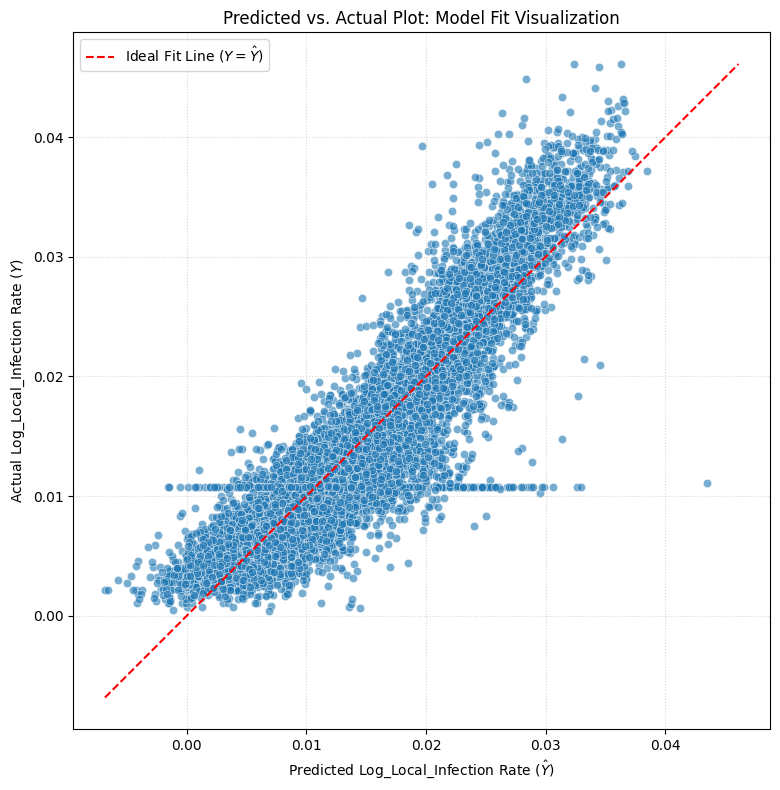

In [55]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_pred_test, y=y_test_array, alpha=0.6)
max_val = max(y_test_array.max(), y_pred_test.max())
min_val = min(y_test_array.min(), y_pred_test.min())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', 
         label='Ideal Fit Line ($Y=\hat{Y}$)')

plt.title('Predicted vs. Actual Plot: Model Fit Visualization')
plt.xlabel('Predicted Log_Local_Infection Rate ($\hat{Y}$)')
plt.ylabel('Actual Log_Local_Infection Rate ($Y$)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('predicted_vs_actual_fit.png')
print("Predicted vs. Actual plot saved as predicted_vs_actual_fit.png")

While the tight clustering of data points along the red diagonal line confirm the prediction capability of the model, it is worth remembering that local infection rate is measured after the on demand scan. Given the current environment, the features actually drive the prediction to have a statistical baseline for what the log-transformed local infection rate should be. The line can be used as the statistical risk to understand which are the severe attacks that will appear as the outliers. 

We can see in the chart that those who are really far from the line are where the highest residuals are. These signal events where the infection rate was far higher than what the original model has expected based on known factors. The recommendations is to dive into these to fully understand where should the improvements be and to know if these are zero-day attacks or new threats that should be explored to know how to defend against it in the future.